In [20]:
from helpers import get_client, get_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

sns.set_style('whitegrid')
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

In [35]:
es = get_client()  
idle = get_data("aggregated-curr-udplatency-*", es)
down_lul = get_data("aggregated-curr-dlping-*", es)
down_speed = get_data("aggregated-curr-httpgetmt-*", es)
up_lul = get_data("aggregated-curr-ulping-*", es)
up_speed = get_data("aggregated-curr-httppostmt-*", es)

for df in (idle, down_lul, down_speed, up_lul, up_speed):
    df['date'] = pd.to_datetime(df['date'])

Connected to Elasticsearch.


## Download Speed & Download Latency

In [ ]:
df1 = pd.merge(down_speed, down_lul, on=['date', 'unit_id', 'operator_name', 'operator_technology'], how='inner')
df1['ratio'] = df1['throughput']/(df1['rtt_avg']*1000)

/tmp/ipykernel_153614/655490847.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df1['year_month'] = df1['date'].dt.to_period('M').dt.to_timestamp()


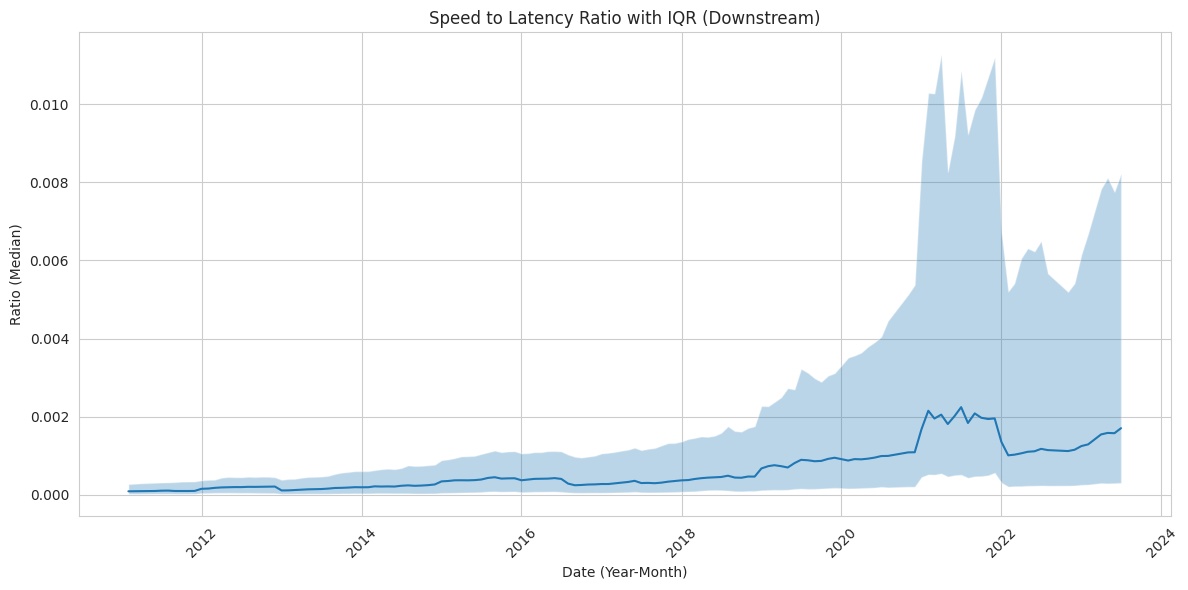

In [11]:
# Create a year-month timestamp
df1['year_month'] = df1['date'].dt.to_period('M').dt.to_timestamp()

# Compute median and IQR bounds
agg = (
    df1.groupby('year_month')['ratio']
      .agg(
          median='median',
          q1=lambda x: x.quantile(0.25),
          q3=lambda x: x.quantile(0.75)
      )
      .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg, x='year_month', y='median')
plt.fill_between(agg['year_month'], agg['q1'], agg['q3'], alpha=0.3)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Ratio (Median)')
plt.title('Speed to Latency Ratio with IQR (Downstream)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/speed_to_lat_ratio/downstream_ratio.png', dpi=600)
plt.show()

/tmp/ipykernel_153614/4042012705.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()


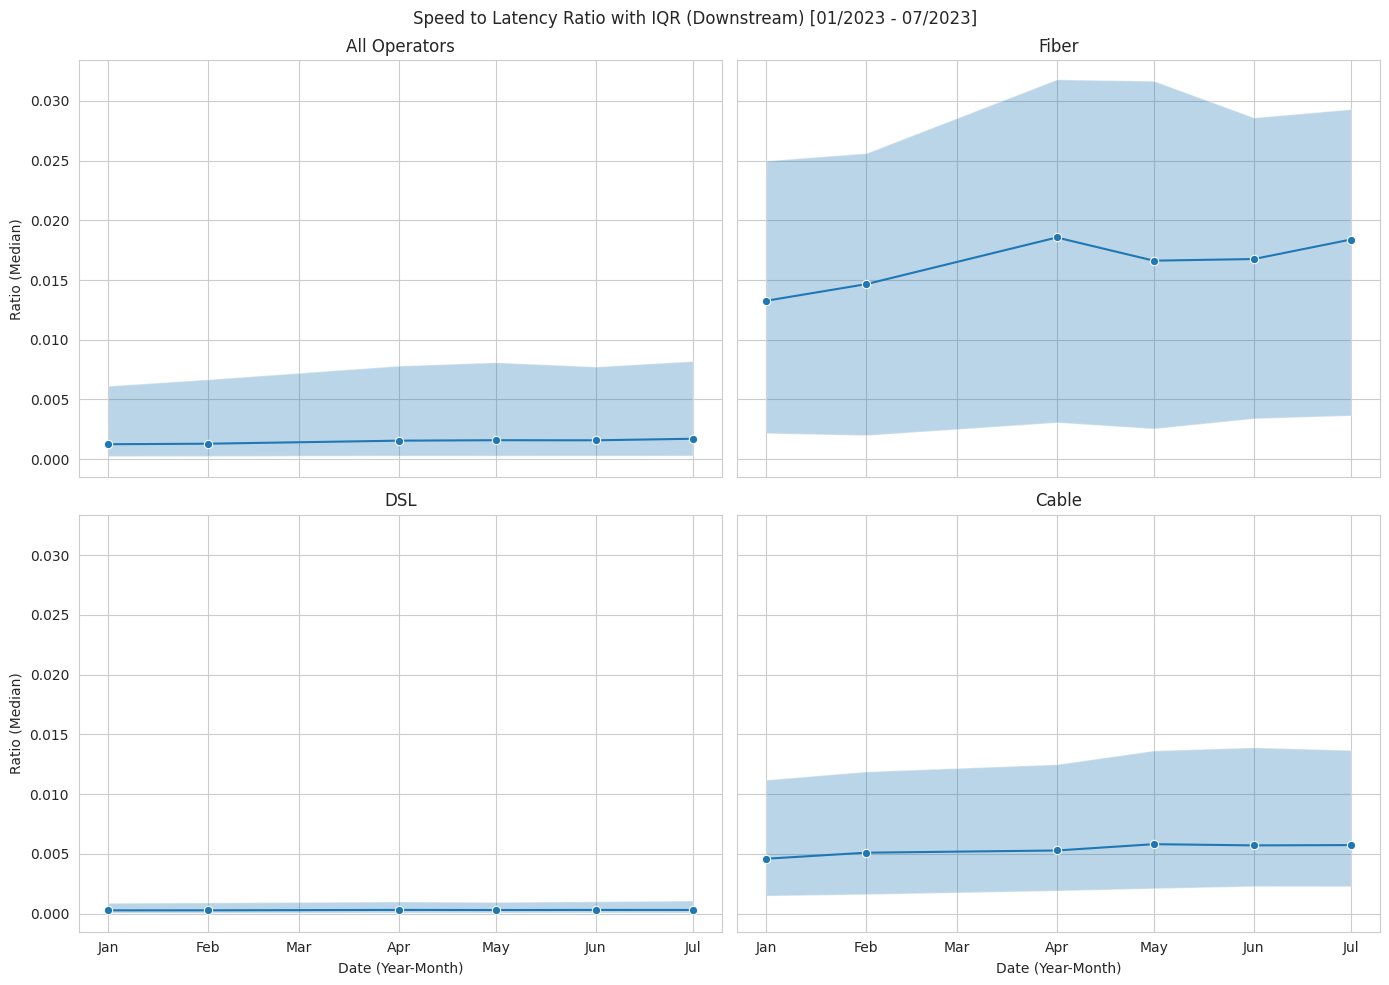

In [13]:
# ADD ONE MORE FOR 2023 & (by technology - cable, fiber, dsl, overall)

# 1. Filter to Jan–Jul 2023
mask = (df1['date'] >= '2023-01-01') & (df1['date'] < '2023-08-01')
df2023 = df1.loc[mask].copy()

# 2. Create year-month timestamp
df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()

# 3. Compute median & IQR for “All operators”
agg_all = (
    df2023
    .groupby('year_month')['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 4. Compute median & IQR by operator_technology
agg_by_op = (
    df2023
    .groupby(['operator_technology', 'year_month'])['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 5. Plot four subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()
categories = ['All operators', 'Fiber', 'DSL', 'Cable']

for ax, cat in zip(axes, categories):
    if cat == 'All operators':
        data = agg_all
        title = 'All Operators'
    else:
        data = agg_by_op[agg_by_op['operator_technology'] == cat]
        title = cat

    # draw median line only where data exists
    sns.lineplot(
        data=data,
        x='year_month', y='median',
        marker='o',
        ax=ax
    )
    # fill IQR
    ax.fill_between(
        data['year_month'],
        data['q1'],
        data['q3'],
        alpha=0.3
    )

    ax.set_title(f'{title}')
    ax.set_xlabel('Date (Year-Month)')
    ax.set_ylabel('Ratio (Median)')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.suptitle('Speed to Latency Ratio with IQR (Downstream) [01/2023 - 07/2023]')
plt.tight_layout()
plt.savefig('plots/speed_to_lat_ratio/downstream2023_ratio.png', dpi=600)
plt.show()

/tmp/ipykernel_153614/1748009393.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()


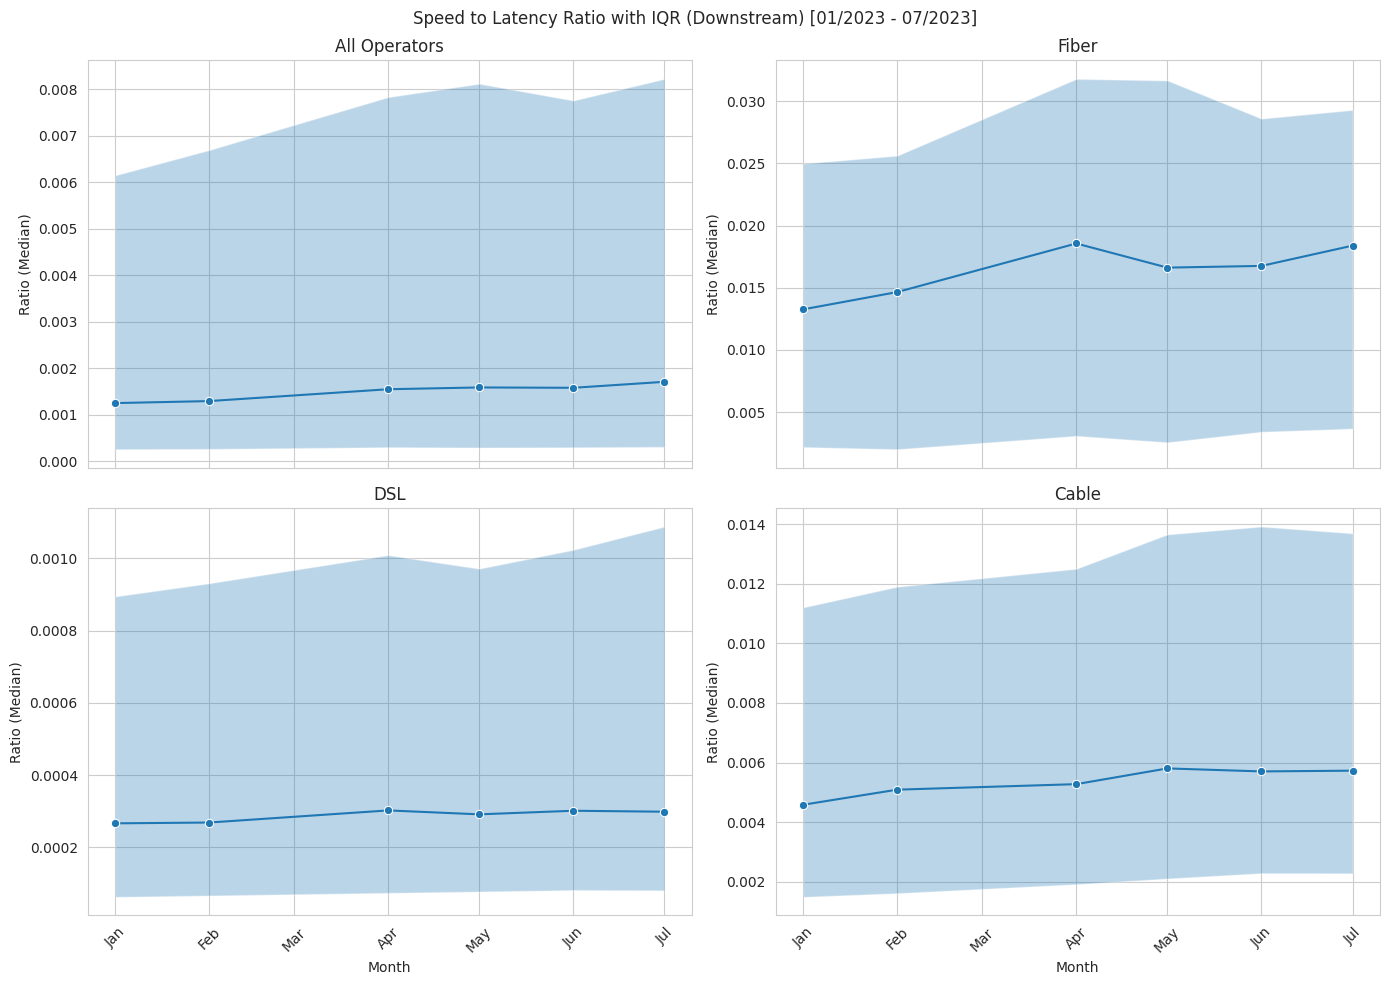

In [43]:
# 1. Filter to Jan–Jul 2023
mask = (df1['date'] >= '2023-01-01') & (df1['date'] < '2023-08-01')
df2023 = df1.loc[mask].copy()

# 2. Create year-month timestamp
df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()

# 3. Compute median & IQR for “All operators”
agg_all = (
    df2023
    .groupby('year_month')['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 4. Compute median & IQR by operator_technology
agg_by_op = (
    df2023
    .groupby(['operator_technology', 'year_month'])['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 5. Plot four subplots, share X but not Y
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
axes = axes.flatten()
categories = ['All operators', 'Fiber', 'DSL', 'Cable']

for ax, cat in zip(axes, categories):
    if cat == 'All operators':
        data = agg_all
        title = 'All Operators'
    else:
        data = agg_by_op[agg_by_op['operator_technology'] == cat]
        title = cat

    sns.lineplot(
        data=data,
        x='year_month', y='median',
        marker='o',
        ax=ax
    )
    ax.fill_between(
        data['year_month'],
        data['q1'],
        data['q3'],
        alpha=0.3
    )

    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Ratio (Median)')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # or '%m' for numbers
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Speed to Latency Ratio with IQR (Downstream) [01/2023 - 07/2023]')
plt.tight_layout()
plt.show()


## Upstream Speed & Upstream Latency

In [37]:
def first_or_none(x):
    if isinstance(x, list):
        return x[0] if x else None
    return x

up_speed['operator_name'] = up_speed['operator_name'].apply(first_or_none)

In [39]:
for col in ['date','unit_id','operator_name','operator_technology']:
    print(col, up_speed[col].apply(lambda x: isinstance(x, list)).any(),
              up_lul[col].apply(lambda x: isinstance(x, list)).any())


date False False
unit_id False False
operator_name False False
operator_technology False False


In [40]:
df3 = pd.merge(up_speed, up_lul, on=['date', 'unit_id', 'operator_name', 'operator_technology'], how='inner')
df3['ratio'] = df3['throughput']/(df3['rtt_avg']*1000)

/tmp/ipykernel_153614/1330582287.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df3['year_month'] = df3['date'].dt.to_period('M').dt.to_timestamp()


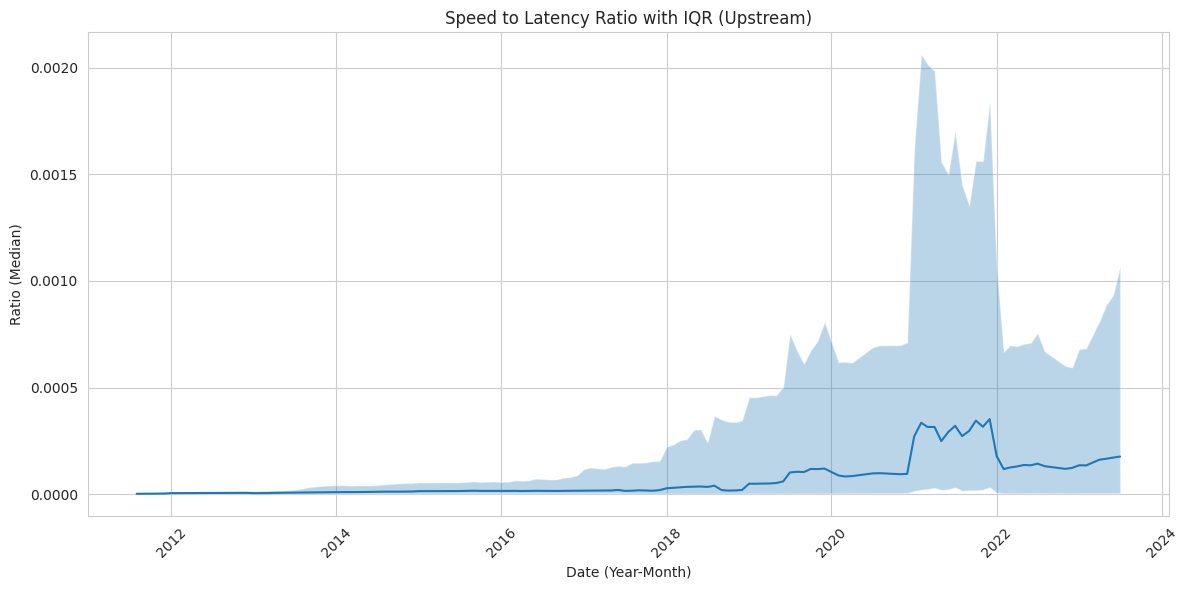

In [41]:
# Create a year-month timestamp
df3['year_month'] = df3['date'].dt.to_period('M').dt.to_timestamp()

# Compute median and IQR bounds
agg = (
    df3.groupby('year_month')['ratio']
      .agg(
          median='median',
          q1=lambda x: x.quantile(0.25),
          q3=lambda x: x.quantile(0.75)
      )
      .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg, x='year_month', y='median')
plt.fill_between(agg['year_month'], agg['q1'], agg['q3'], alpha=0.3)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Ratio (Median)')
plt.title('Speed to Latency Ratio with IQR (Upstream)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./plots/speed_to_lat_ratio/upstream_ratio.png', dpi=600)
plt.show()

/tmp/ipykernel_153614/749119885.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()


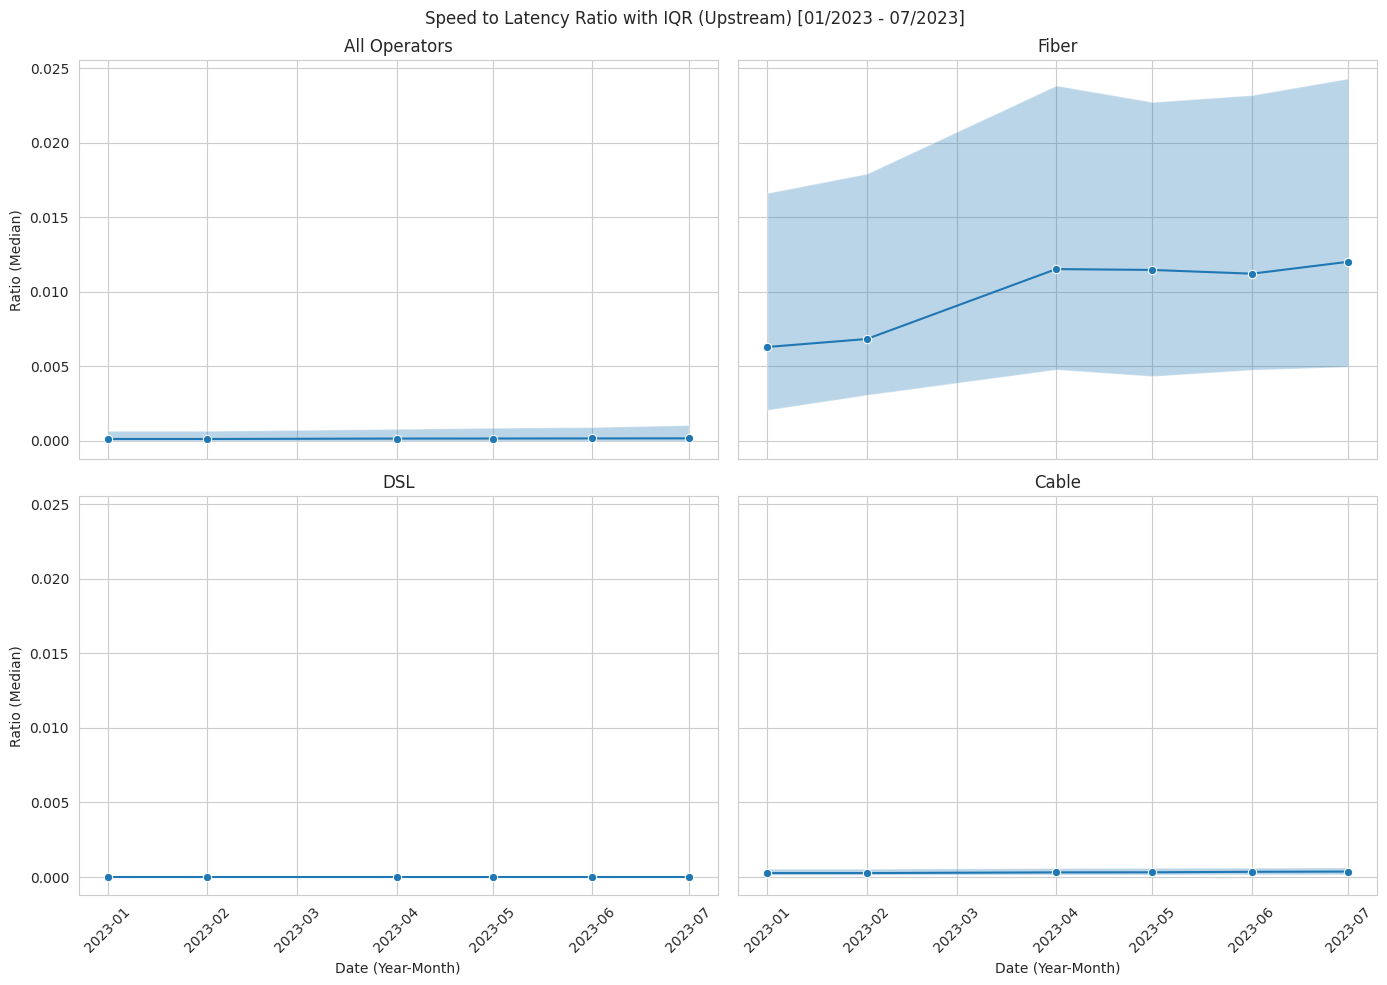

In [42]:
# ADD ONE MORE FOR 2023 & (by technology - cable, fiber, dsl, overall)

# 1. Filter to Jan–Jul 2023
mask = (df3['date'] >= '2023-01-01') & (df3['date'] < '2023-08-01')
df2023 = df3.loc[mask].copy()

# 2. Create year-month timestamp
df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()

# 3. Compute median & IQR for “All operators”
agg_all = (
    df2023
    .groupby('year_month')['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 4. Compute median & IQR by operator_technology
agg_by_op = (
    df2023
    .groupby(['operator_technology', 'year_month'])['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 5. Plot four subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()
categories = ['All operators', 'Fiber', 'DSL', 'Cable']

for ax, cat in zip(axes, categories):
    if cat == 'All operators':
        data = agg_all
        title = 'All Operators'
    else:
        data = agg_by_op[agg_by_op['operator_technology'] == cat]
        title = cat

    # draw median line only where data exists
    sns.lineplot(
        data=data,
        x='year_month', y='median',
        marker='o',
        ax=ax
    )
    # fill IQR
    ax.fill_between(
        data['year_month'],
        data['q1'],
        data['q3'],
        alpha=0.3
    )

    ax.set_title(f'{title}')
    ax.set_xlabel('Date (Year-Month)')
    ax.set_ylabel('Ratio (Median)')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Speed to Latency Ratio with IQR (Upstream) [01/2023 - 07/2023]')
plt.tight_layout()
plt.savefig('plots/speed_to_lat_ratio/upstream2023_ratio.png', dpi=600)
plt.show()

## Download Speed & Idle Latency

In [ ]:
df2 = pd.merge(down_speed, idle, on=['date', 'unit_id', 'operator_name', 'operator_technology'], how='inner')
df2['ratio'] = df2['throughput']/(df2['rtt_avg'] * 1000)
df2.head()

In [ ]:
# Create a year-month timestamp
df2['year_month'] = df2['date'].dt.to_period('M').dt.to_timestamp()

# Compute median and IQR bounds
agg = (
    df2.groupby('year_month')['ratio']
      .agg(
          median='median',
          q1=lambda x: x.quantile(0.25),
          q3=lambda x: x.quantile(0.75)
      )
      .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg, x='year_month', y='median')
plt.fill_between(agg['year_month'], agg['q1'], agg['q3'], alpha=0.3)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Ratio (Median)')
plt.title('Speed to Latency Ratio with IQR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ADD ONE MORE FOR 2023 & (by technology - cable, fiber, dsl, overall)

# 1. Filter to Jan–Jul 2023
mask = (df2['date'] >= '2023-01-01') & (df2['date'] < '2023-08-01')
df2023 = df2.loc[mask].copy()

# 2. Create year-month timestamp
df2023['year_month'] = df2023['date'].dt.to_period('M').dt.to_timestamp()

# 3. Compute median & IQR for “All operators”
agg_all = (
    df2023
    .groupby('year_month')['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 4. Compute median & IQR by operator_technology
agg_by_op = (
    df2023
    .groupby(['operator_technology', 'year_month'])['ratio']
    .agg(
        median='median',
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# 5. Plot four subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()
categories = ['All operators', 'Fiber', 'DSL', 'Cable']

for ax, cat in zip(axes, categories):
    if cat == 'All operators':
        data = agg_all
        title = 'All Operators'
    else:
        data = agg_by_op[agg_by_op['operator_technology'] == cat]
        title = cat

    # draw median line only where data exists
    sns.lineplot(
        data=data,
        x='year_month', y='median',
        marker='o',
        ax=ax
    )
    # fill IQR
    ax.fill_between(
        data['year_month'],
        data['q1'],
        data['q3'],
        alpha=0.3
    )

    ax.set_title(f'{title}')
    ax.set_xlabel('Date (Year-Month)')
    ax.set_ylabel('Ratio (Median)')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Speed to Latency Ratio with IQR')
plt.tight_layout()
plt.savefig('plots/speed_to_lat_ratio/downstream2023_ratio.png', dpi=600)
plt.show()

In [ ]:
def prepare(df):
    # 1) ensure datetime
    df['date'] = pd.to_datetime(df['date'])
    # 2) extract month-buckets
    df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    # 3) aggregate median and IQR
    agg = (
        df.groupby('year_month')['ratio']
          .agg(
              median='median',
              q1=lambda x: x.quantile(0.25),
              q3=lambda x: x.quantile(0.75)
          )
          .reset_index()
    )
    return agg

# Prepare both
agg1 = prepare(df1)
agg2 = prepare(df2)


In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 8))

for ax, agg, title in zip(axes, [agg1, agg2], ['Speed vs LUL', 'Speed vs Idle']):
    sns.lineplot(data=agg, x='year_month', y='median', ax=ax)
    ax.fill_between(agg['year_month'], agg['q1'], agg['q3'], alpha=0.3)
    ax.set_title(title)
    ax.set_ylabel('Median Ratio')

axes[-1].set_xlabel('Date (Year-Month)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

# Plot DF1
sns.lineplot(data=agg1, x='year_month', y='median', label='Speed vs LUL')
plt.fill_between(agg1['year_month'], agg1['q1'], agg1['q3'], alpha=0.3)

# Plot DF2
sns.lineplot(data=agg2, x='year_month', y='median', label='Speed vs Idle')
plt.fill_between(agg2['year_month'], agg2['q1'], agg2['q3'], alpha=0.3)

plt.xlabel('Date (Year-Month)')
plt.ylabel('Median Ratio')
plt.title('Comparison of Monthly Median Ratio with IQR')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()